### III. Feature Selection, Algorithm improvement, Generalization demo.

In this part, we create a model, we try different algorithms and see which one delivers the best results. Then we chose the best algorithm and fine tune it. 

This notebook presents the following parts:

    1) Model creation
    2) Feature Selection (hybrid method recursive feature elimination)
    3) Algorithm testing
        - verify reduce dataset gives goods results
    4) Improve the model (fine tune hyperparameters)
        - verify improved model delivers a better metric
    5) Save Model for inference
    6) Show evidence the new model will generalize well

In [1]:
# import libraries
import pandas as pd
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import math
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import xgboost as xgb
from sklearn.metrics import roc_auc_score, r2_score

from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, SelectPercentile

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.feature_selection import f_classif, f_regression
from sklearn.metrics import mean_squared_log_error



%matplotlib inline
%matplotlib inline

In [2]:
#import data set
df=pd.read_csv('dfformodeling.csv')
df.shape

(3198, 44)

In [3]:
df.head(2)

,demo__birth_rate_per_1k,demo__death_rate_per_1k,demo__pct_adults_bachelors_or_higher,demo__pct_adults_less_than_a_high_school_diploma,demo__pct_adults_with_high_school_diploma,demo__pct_adults_with_some_college,demo__pct_american_indian_or_alaskan_native,demo__pct_asian,demo__pct_below_18_years_of_age,demo__pct_female,...,Economic_typo:_Federal/State government-dependent,Economic_typo:_Manufacturing-dependent,Economic_typo:_Mining_farming,Economic_typo:_Nonspecialized,Economic_typo:_Recreation,Area_rucc:_Metro,Area_rucc:_NonMetro,Age_Group:_old,Age_Group:_young,heart_disease_mortality_per_100k
0,0.117909,0.609758,-0.504912,0.665733,1.045102,-1.415408,-0.244441,-0.082609,0.212671,0.704488,...,-0.37262,2.339225,-0.546672,-0.809367,-0.328747,1.354449,-1.354449,-0.511328,0.511328,312
1,2.673105,-1.184837,0.670671,0.224590,-1.651557,0.789570,-0.197126,0.074713,1.292277,0.171536,...,-0.37262,-0.427358,1.828678,-0.809367,-0.328747,1.354449,-1.354449,-0.511328,0.511328,257


**1) Model Creation**

In [4]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(labels=['heart_disease_mortality_per_100k'], axis=1),
    df['heart_disease_mortality_per_100k'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape


((2238, 43), (960, 43))

In [5]:
# I keep a copy of the dataset with all the variables
# to measure the performance of machine learning models
# at the end of the notebook

X_train_original = X_train.copy()
X_test_original = X_test.copy()

**2) Features Selection (hybrid method:Hybrid recursive feature elimination)**

From the previous notebook I know the best model is the Random Forest, so I create a hybrid method to select the best features for this algorithm. 

In [6]:
# the first step of this procedure consists in building
# a machine learning algorithm using all the available features
# and then determine the importance of the features according
# to the algorithm

# set the seed for reproducibility
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model using all the features
model_all_features = RandomForestRegressor()

model_all_features.fit(X_train, y_train)

# calculate the roc-auc in the test set
y_pred_test = model_all_features.predict(X_test)
r2_score_all = r2_score(y_test, y_pred_test)
print('Test all features rdf R2 = %f' % (r2_score_all))

/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Test all features rdf R2 = 0.677933


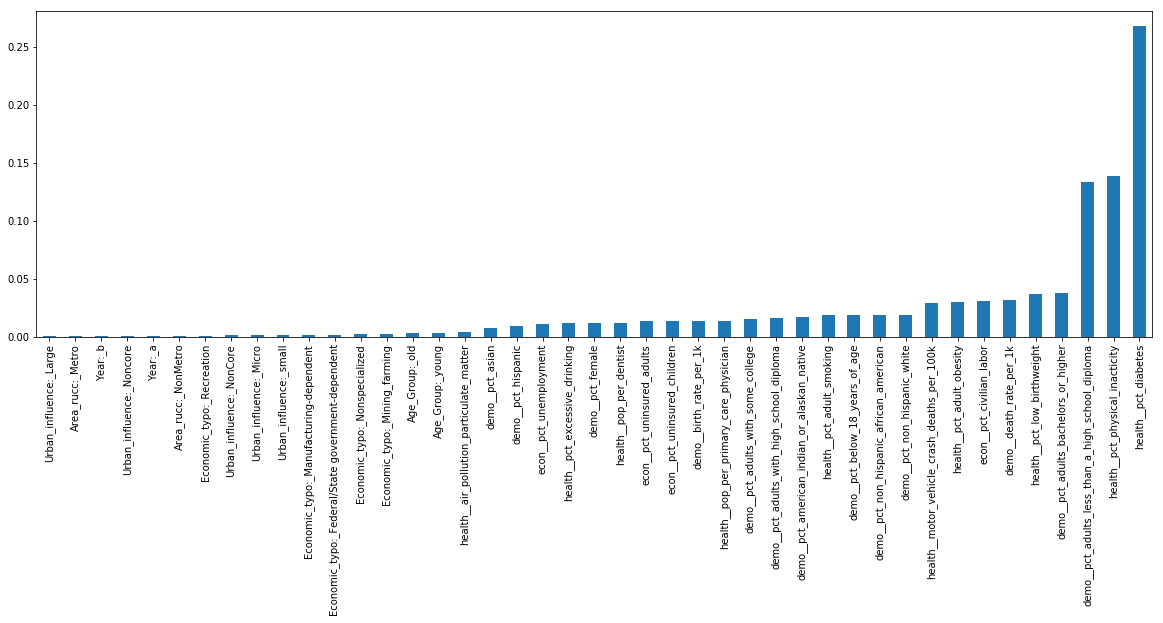

In [7]:
# the second step consist of deriving the importance of 
# each feature and ranking them from the most to the least
# important

# get feature name and importance
features = pd.Series(model_all_features.feature_importances_)
features.index = X_train.columns

# sort the features by importance
features.sort_values(ascending=True, inplace=True)

# plot
features.plot.bar(figsize=(20,6))

In [8]:
# view the list of ordered features
features = list(features.index)
features

['Urban_influence:_Large',
 'Area_rucc:_Metro',
 'Year:_b',
 'Urban_influence:_Noncore',
 'Year:_a',
 'Area_rucc:_NonMetro',
 'Economic_typo:_Recreation',
 'Urban_influence:_NonCore',
 'Urban_influence:_Micro',
 'Urban_influence:_small',
 'Economic_typo:_Manufacturing-dependent',
 'Economic_typo:_Federal/State government-dependent',
 'Economic_typo:_Nonspecialized',
 'Economic_typo:_Mining_farming',
 'Age_Group:_old',
 'Age_Group:_young',
 'health__air_pollution_particulate_matter',
 'demo__pct_asian',
 'demo__pct_hispanic',
 'econ__pct_unemployment',
 'health__pct_excessive_drinking',
 'demo__pct_female',
 'health__pop_per_dentist',
 'econ__pct_uninsured_adults',
 'econ__pct_uninsured_children',
 'demo__birth_rate_per_1k',
 'health__pop_per_primary_care_physician',
 'demo__pct_adults_with_some_college',
 'demo__pct_adults_with_high_school_diploma',
 'demo__pct_american_indian_or_alaskan_native',
 'health__pct_adult_smoking',
 'demo__pct_below_18_years_of_age',
 'demo__pct_non_hispanic

In [9]:
# the final step consists in removing one at a time
# all the features, from the least to the most
# important, and build an xgboost at each round.

# once we build the model, we calculate the new r2
# if the new r2 is smaller than the original one
# (with all the features), then that feature that was removed
# was important, and we should keep it.
# otherwise, we should remove the feature

# recursive feature elimination:

# first we arbitrarily set the drop in r2
# if the drop is below this threshold,
# the feature will be removed
tol = 0.001

print('doing recursive feature elimination')

# we initialise a list where we will collect the
# features we should remove
features_to_remove = []

# set a counter to know how far ahead the loop is going
count = 1

# now we loop over all the features, in order of importance:
# remember that features is the list of ordered features
# by importance
for feature in features:
    print()
    print('testing feature: ', feature, ' which is feature ', count,
          ' out of ', len(features))
    count = count + 1

    # initialise model
    model_int = xgb.XGBRegressor(
        nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

    # fit model with all variables minus the removed features
    # and the feature to be evaluated
    model_int.fit(
        X_train.drop(features_to_remove + [feature], axis=1), y_train)

    # make a prediction over the test set
    y_pred_test = model_int.predict(
        X_test.drop(features_to_remove + [feature], axis=1))

    # calculate the new r2
    r2_score_int = r2_score(y_test, y_pred_test)
    print('New Test r2 = {}'.format((r2_score_int)))

    # print the original r2 with all the features
    print('All features Test r2 = {}'.format((r2_score_all)))

    # determine the drop in the r2
    diff_r2 = r2_score_all - r2_score_int

    # compare the drop in r2 with the tolerance
    # we set previously
    if diff_r2 >= tol:
        print('Drop in r2 ={}'.format(diff_r2))
        print('keep: ', feature)
        print
    else:
        print('Drop in r2 = {}'.format(diff_r2))
        print('remove: ', feature)
        print
        # if the drop in the r2 is small and we remove the
        # feature, we need to set the new r2 to the one based on
        # the remaining features
        r2_score_all = r2_score_int
        
        # and append the feature to remove to the collecting
        # list
        features_to_remove.append(feature)

# now the loop is finished, we evaluated all the features
print('DONE!!')
print('total features to remove: ', len(features_to_remove))

# determine the features to keep (those we won't remove)
features_to_keep = [x for x in features if x not in features_to_remove]
print('total features to keep: ', len(features_to_keep))

doing recursive feature elimination

testing feature:  Urban_influence:_Large  which is feature  1  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.7348143258615689
All features Test r2 = 0.677933243032782
Drop in r2 = -0.0568810828287869
remove:  Urban_influence:_Large

testing feature:  Area_rucc:_Metro  which is feature  2  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.7348143258615689
All features Test r2 = 0.7348143258615689
Drop in r2 = 0.0
remove:  Area_rucc:_Metro

testing feature:  Year:_b  which is feature  3  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.7348143258615689
All features Test r2 = 0.7348143258615689
Drop in r2 = 0.0
remove:  Year:_b

testing feature:  Urban_influence:_Noncore  which is feature  4  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.734636733685788
All features Test r2 = 0.7348143258615689
Drop in r2 = 0.00017759217578094955
remove:  Urban_influence:_Noncore

testing feature:  Year:_a  which is feature  5  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.744617863304129
All features Test r2 = 0.734636733685788
Drop in r2 = -0.009981129618341078
remove:  Year:_a

testing feature:  Area_rucc:_NonMetro  which is feature  6  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.7437353293152305
All features Test r2 = 0.744617863304129
Drop in r2 = 0.0008825339888985928
remove:  Area_rucc:_NonMetro

testing feature:  Economic_typo:_Recreation  which is feature  7  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.741727139163737
All features Test r2 = 0.7437353293152305
Drop in r2 =0.0020081901514934497
keep:  Economic_typo:_Recreation

testing feature:  Urban_influence:_NonCore  which is feature  8  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.7400492037976583
All features Test r2 = 0.7437353293152305
Drop in r2 =0.003686125517572192
keep:  Urban_influence:_NonCore

testing feature:  Urban_influence:_Micro  which is feature  9  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.7446808638500464
All features Test r2 = 0.7437353293152305
Drop in r2 = -0.0009455345348159394
remove:  Urban_influence:_Micro

testing feature:  Urban_influence:_small  which is feature  10  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.7406986698733042
All features Test r2 = 0.7446808638500464
Drop in r2 =0.003982193976742154
keep:  Urban_influence:_small

testing feature:  Economic_typo:_Manufacturing-dependent  which is feature  11  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.7346077751837558
All features Test r2 = 0.7446808638500464
Drop in r2 =0.010073088666290642
keep:  Economic_typo:_Manufacturing-dependent

testing feature:  Economic_typo:_Federal/State government-dependent  which is feature  12  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.7394846375155887
All features Test r2 = 0.7446808638500464
Drop in r2 =0.00519622633445771
keep:  Economic_typo:_Federal/State government-dependent

testing feature:  Economic_typo:_Nonspecialized  which is feature  13  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.7455455230079897
All features Test r2 = 0.7446808638500464
Drop in r2 = -0.0008646591579433149
remove:  Economic_typo:_Nonspecialized

testing feature:  Economic_typo:_Mining_farming  which is feature  14  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.7412087660744351
All features Test r2 = 0.7455455230079897
Drop in r2 =0.00433675693355462
keep:  Economic_typo:_Mining_farming

testing feature:  Age_Group:_old  which is feature  15  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.7455455230079897
All features Test r2 = 0.7455455230079897
Drop in r2 = 0.0
remove:  Age_Group:_old

testing feature:  Age_Group:_young  which is feature  16  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.7382247850815261
All features Test r2 = 0.7455455230079897
Drop in r2 =0.007320737926463594
keep:  Age_Group:_young

testing feature:  health__air_pollution_particulate_matter  which is feature  17  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.7348802962869441
All features Test r2 = 0.7455455230079897
Drop in r2 =0.01066522672104564
keep:  health__air_pollution_particulate_matter

testing feature:  demo__pct_asian  which is feature  18  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.741464449343533
All features Test r2 = 0.7455455230079897
Drop in r2 =0.004081073664456758
keep:  demo__pct_asian

testing feature:  demo__pct_hispanic  which is feature  19  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.7433587425703596
All features Test r2 = 0.7455455230079897
Drop in r2 =0.002186780437630098
keep:  demo__pct_hispanic

testing feature:  econ__pct_unemployment  which is feature  20  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.7459165538130245
All features Test r2 = 0.7455455230079897
Drop in r2 = -0.0003710308050347555
remove:  econ__pct_unemployment

testing feature:  health__pct_excessive_drinking  which is feature  21  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.7349951063211169
All features Test r2 = 0.7459165538130245
Drop in r2 =0.010921447491907599
keep:  health__pct_excessive_drinking

testing feature:  demo__pct_female  which is feature  22  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.7448343270050712
All features Test r2 = 0.7459165538130245
Drop in r2 =0.0010822268079532238
keep:  demo__pct_female

testing feature:  health__pop_per_dentist  which is feature  23  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.7416349428785851
All features Test r2 = 0.7459165538130245
Drop in r2 =0.0042816109344393505
keep:  health__pop_per_dentist

testing feature:  econ__pct_uninsured_adults  which is feature  24  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.7424805489217289
All features Test r2 = 0.7459165538130245
Drop in r2 =0.0034360048912955854
keep:  econ__pct_uninsured_adults

testing feature:  econ__pct_uninsured_children  which is feature  25  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.7325873462926034
All features Test r2 = 0.7459165538130245
Drop in r2 =0.013329207520421105
keep:  econ__pct_uninsured_children

testing feature:  demo__birth_rate_per_1k  which is feature  26  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.7445619742324282
All features Test r2 = 0.7459165538130245
Drop in r2 =0.0013545795805962602
keep:  demo__birth_rate_per_1k

testing feature:  health__pop_per_primary_care_physician  which is feature  27  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.7374305048230794
All features Test r2 = 0.7459165538130245
Drop in r2 =0.008486048989945094
keep:  health__pop_per_primary_care_physician

testing feature:  demo__pct_adults_with_some_college  which is feature  28  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.7399243742386896
All features Test r2 = 0.7459165538130245
Drop in r2 =0.005992179574334844
keep:  demo__pct_adults_with_some_college

testing feature:  demo__pct_adults_with_high_school_diploma  which is feature  29  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.7422481371636348
All features Test r2 = 0.7459165538130245
Drop in r2 =0.003668416649389661
keep:  demo__pct_adults_with_high_school_diploma

testing feature:  demo__pct_american_indian_or_alaskan_native  which is feature  30  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.7392326543890019
All features Test r2 = 0.7459165538130245
Drop in r2 =0.006683899424022588
keep:  demo__pct_american_indian_or_alaskan_native

testing feature:  health__pct_adult_smoking  which is feature  31  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.7332731751937538
All features Test r2 = 0.7459165538130245
Drop in r2 =0.012643378619270673
keep:  health__pct_adult_smoking

testing feature:  demo__pct_below_18_years_of_age  which is feature  32  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.7402971876842697
All features Test r2 = 0.7459165538130245
Drop in r2 =0.005619366128754799
keep:  demo__pct_below_18_years_of_age

testing feature:  demo__pct_non_hispanic_african_american  which is feature  33  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.7383657896503175
All features Test r2 = 0.7459165538130245
Drop in r2 =0.007550764162706947
keep:  demo__pct_non_hispanic_african_american

testing feature:  demo__pct_non_hispanic_white  which is feature  34  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.7400673648105345
All features Test r2 = 0.7459165538130245
Drop in r2 =0.005849189002489985
keep:  demo__pct_non_hispanic_white

testing feature:  health__motor_vehicle_crash_deaths_per_100k  which is feature  35  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.7254492101449155
All features Test r2 = 0.7459165538130245
Drop in r2 =0.020467343668108984
keep:  health__motor_vehicle_crash_deaths_per_100k

testing feature:  health__pct_adult_obesity  which is feature  36  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.736051301640197
All features Test r2 = 0.7459165538130245
Drop in r2 =0.00986525217282741
keep:  health__pct_adult_obesity

testing feature:  econ__pct_civilian_labor  which is feature  37  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.7442298557588043
All features Test r2 = 0.7459165538130245
Drop in r2 =0.0016866980542201704
keep:  econ__pct_civilian_labor

testing feature:  demo__death_rate_per_1k  which is feature  38  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.7364858679501749
All features Test r2 = 0.7459165538130245
Drop in r2 =0.009430685862849564
keep:  demo__death_rate_per_1k

testing feature:  health__pct_low_birthweight  which is feature  39  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.7471659562994355
All features Test r2 = 0.7459165538130245
Drop in r2 = -0.0012494024864110331
remove:  health__pct_low_birthweight

testing feature:  demo__pct_adults_bachelors_or_higher  which is feature  40  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.7397057401078693
All features Test r2 = 0.7471659562994355
Drop in r2 =0.007460216191566227
keep:  demo__pct_adults_bachelors_or_higher

testing feature:  demo__pct_adults_less_than_a_high_school_diploma  which is feature  41  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.7268345994059566
All features Test r2 = 0.7471659562994355
Drop in r2 =0.02033135689347887
keep:  demo__pct_adults_less_than_a_high_school_diploma

testing feature:  health__pct_physical_inacticity  which is feature  42  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.7343874097296512
All features Test r2 = 0.7471659562994355
Drop in r2 =0.012778546569784277
keep:  health__pct_physical_inacticity

testing feature:  health__pct_diabetes  which is feature  43  out of  43


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


New Test r2 = 0.7468166187919221
All features Test r2 = 0.7471659562994355
Drop in r2 = 0.0003493375075134253
remove:  health__pct_diabetes
DONE!!
total features to remove:  12
total features to keep:  31


In [10]:
# capture the 31 selected features
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model
final_xgb = xgb.XGBRegressor(
    nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

# fit the model with the selected features
final_xgb.fit(X_train[features_to_keep], y_train)

# make predictions
y_pred_test = final_xgb.predict(X_test[features_to_keep])

# calculate roc-auc
r2_score_final = r2_score(y_test, y_pred_test)
print('Test selected features r2 = %f' % (r2_score_final))


/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test selected features r2 = 0.747415


In [11]:
X_train[features_to_keep].columns

Index(['Economic_typo:_Recreation', 'Urban_influence:_NonCore',
       'Urban_influence:_small', 'Economic_typo:_Manufacturing-dependent',
       'Economic_typo:_Federal/State government-dependent',
       'Economic_typo:_Mining_farming', 'Age_Group:_young',
       'health__air_pollution_particulate_matter', 'demo__pct_asian',
       'demo__pct_hispanic', 'health__pct_excessive_drinking',
       'demo__pct_female', 'health__pop_per_dentist',
       'econ__pct_uninsured_adults', 'econ__pct_uninsured_children',
       'demo__birth_rate_per_1k', 'health__pop_per_primary_care_physician',
       'demo__pct_adults_with_some_college',
       'demo__pct_adults_with_high_school_diploma',
       'demo__pct_american_indian_or_alaskan_native',
       'health__pct_adult_smoking', 'demo__pct_below_18_years_of_age',
       'demo__pct_non_hispanic_african_american',
       'demo__pct_non_hispanic_white',
       'health__motor_vehicle_crash_deaths_per_100k',
       'health__pct_adult_obesity', 'econ__p

We have reduced the features space from 43 to 31 plus the label, and we improved R2 from 0.67 to 0.747!

**2) Improve algorithm XGB Regressor**

First I import libraries

In [25]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import datetime
from sklearn.model_selection import GridSearchCV

Then I look for the best hyperparameters

In [33]:
improved_xgb = xgb.XGBRegressor()
parameters = {'nthread':[4,10], #when use hyperthread, xgboost may become slower
              'learning_rate': [.03, 0.05,0.1,0.3,0.5], #so called `eta` value
              'max_depth': [3, 4, 5],
              'n_estimators': [500,1000]}

xgb_grid = GridSearchCV(improved_xgb,
                        parameters,
                        cv = 5,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train[features_to_keep], y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.5min
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  8.6min
[Parallel(n_jobs=5)]: Done 300 out of 300 | elapsed: 13.7min finished


0.7581099692248686
{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 1000, 'nthread': 4}


Use the improved model with the best parameters found

In [40]:
# Use the best parameters for the improved model
improved_xgb = xgb.XGBRegressor(
    nthread=4, max_depth=5, n_estimators=1000, learning_rate=0.05)

# fit the model with the selected features
improved_xgb.fit(X_train[features_to_keep], y_train)

# make predictions
y_pred_test = improved_xgb.predict(X_test[features_to_keep])

# calculate roc-auc
r2_score_improved = r2_score(y_test, y_pred_test)
print('Improved R2 = %f' % (r2_score_improved))

/anaconda3/envs/featsel/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Improved R2 = 0.771057


4.3 Check for **improvement on R2**

In [41]:
print('Original R2 = %f' % (r2_score_all))
print('Improved R2 = %f' % (r2_score_improved))
print('R2 improvement',(r2_score_improved-r2_score_all))

Original R2 = 0.746817
Improved R2 = 0.771057
R2 improvement 0.024240195696030198


**5. Save model improved**

In [42]:
# Saving LogRec model
from sklearn.externals import joblib
from joblib import dump, load

In [43]:
dump(improved_xgb,'improved_xgb.joblib')  

['improved_xgb.joblib']

**6. Verification that the model created will generalize well**

In [44]:
def print_metrics(y_train, y_test, n_parameters):
    ## First compute R^2 and the adjusted R^2
    r2 = sklm.r2_score(y_train, y_test)
    r2_adj = r2 - (n_parameters - 1)/(y_train.shape[0] - n_parameters) * (1 - r2)
    
    ## Print the usual metrics and the R^2 values
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_train, y_test)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_train, y_test))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_train, y_test)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_train, y_test)))
    print('R^2                    = ' + str(r2))
    print('Adjusted R^2           = ' + str(r2_adj))
   
y_score = improved_xgb.predict(X_test[features_to_keep]) 
print_metrics(y_test, y_score, 28)

Mean Square Error      = 773.0149303073982
Root Mean Square Error = 27.80314605053533
Mean Absolute Error    = 21.121674044926962
Median Absolute Error  = 16.40325164794922
R^2                    = 0.7710568144879523
Adjusted R^2           = 0.7644243402295561


Given the difference between R^2 and Adjusted R2 is so small, we can safely infer that the model will generalize well.

In [45]:
#Lets look at the residuals plot 

## Calculate residuals (y-yhat)
df['residuals']=y_train - y_test

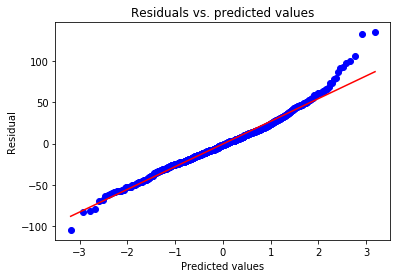

In [46]:
def resid_qq(y_train, y_test):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test, y_score)
    ## now make the residual plots
    ss.probplot(resids, plot = plt)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')
    
resid_qq(y_train, y_test)   

As with the histogram, the Q-Q Normal plot indicates the residuals are close to Normally distributed, show some skew (deviation from the straight line). This is particularly for large residuals.

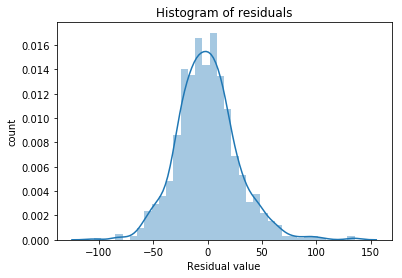

In [47]:
def hist_resids(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test, y_score)
    ## now make the residual plots
    sns.distplot(resids)
    plt.title('Histogram of residuals')
    plt.xlabel('Residual value')
    plt.ylabel('count')
    
hist_resids(y_test, y_score) 

This plot looks reasonable. The residual values are distributed near both sides of 0.

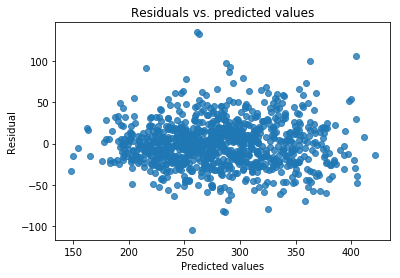

In [48]:
def resid_plot(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test, y_score)
    ## now make the residual plots
    sns.regplot(y_score, resids, fit_reg=False)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')

resid_plot(y_test, y_score)

As expected, when plotting residuals we cannot see any clear pattern. Otherwise it would mean there is a hidden pattern we could not identify.

Consequently, we can conclude the model we have created will generalize well. 